# Pull in all of the necessary packafes and libraries

In [2]:
from pynq import Overlay
from pynq import MMIO
import matplotlib.pyplot as plt
import scipy.ndimage
import matplotlib.image as mpimg
import numpy as np
import cv2
from PIL import Image
from smbus2 import SMBus, i2c_msg
from pynq.ps import Clocks

# Load in the overlay

In [5]:
overlay = Overlay("/usr/local/lib/python3.6/dist-packages/lepton/bitstream/lepton.bit")

Detect the I2C - address we are looking for with the FLIR Lepton is 2A

In [6]:
!i2cdetect -l

i2c-1	i2c       	Cadence I2C at e0005000         	I2C adapter
i2c-0	i2c       	Cadence I2C at e0004000         	I2C adapter


In [7]:
!i2cdetect -r -y 0

     0  1  2  3  4  5  6  7  8  9  a  b  c  d  e  f
00:          -- -- -- -- -- -- -- -- -- -- -- -- -- 
10: -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
20: -- -- -- -- -- -- -- -- -- -- 2a -- -- -- -- -- 
30: -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
40: -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
50: -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
60: -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
70: -- -- -- -- -- -- -- --                         


Check the clock is 4 MHz

In [8]:
Clocks.fclk0_mhz

4.0

# Configure the device, turn on the AGC 

In [9]:
i2c_bus = SMBus(0)
Sensor_addr = 0x2a

In [10]:
write = i2c_msg.write(Sensor_addr, [0x00, 0x02])
read = i2c_msg.read(Sensor_addr, 2)
with SMBus(0) as bus:
    i2c_bus.i2c_rdwr(write, read)

In [11]:
write = i2c_msg.write(Sensor_addr, [0x00, 0x08,0x00,0x01])
with SMBus(0) as bus:
    i2c_bus.i2c_rdwr(write)

In [12]:
write = i2c_msg.write(Sensor_addr, [0x00, 0x0a,0x00,0x00])
with SMBus(0) as bus:
    i2c_bus.i2c_rdwr(write)

In [13]:
write = i2c_msg.write(Sensor_addr, [0x00, 0x06,0x00,0x02])
with SMBus(0) as bus:
    i2c_bus.i2c_rdwr(write)

In [14]:
write = i2c_msg.write(Sensor_addr, [0x00, 0x04,0x01,0x01])
with SMBus(0) as bus:
    i2c_bus.i2c_rdwr(write)

In [15]:
write = i2c_msg.write(Sensor_addr, [0x00, 0x04,0x01,0x00])
read = i2c_msg.read(Sensor_addr, 4)
with SMBus(0) as bus:
    i2c_bus.i2c_rdwr(write, read)

In [16]:
data = list(read)
data

[0, 4, 0, 1]

In [17]:
write = i2c_msg.write(Sensor_addr, [0x00, 0x04,0x02,0x42])
with SMBus(0) as bus:
    i2c_bus.i2c_rdwr(write)

In [18]:
write = i2c_msg.write(Sensor_addr, [0x00, 0x02])
read = i2c_msg.read(Sensor_addr, 2)
with SMBus(0) as bus:
    i2c_bus.i2c_rdwr(write, read)
data = list(read)
data

[0, 6]

Set up the GPIO interface - able to remove reset

In [29]:
gpio = overlay.axi_gpio_0 
gpio.write(0x0,0x1)

Configure the BRAM Interface 

In [30]:
bram  = overlay.ip_dict['axi_bram_ctrl_0']
IP_BASE_ADDRESS = bram['phys_addr']
IP_ADDRESS_RNGE = bram['addr_range']
bram = MMIO(IP_BASE_ADDRESS, IP_ADDRESS_RNGE)

In [31]:
print(hex(IP_BASE_ADDRESS))
print(IP_ADDRESS_RNGE)

0x40000000
32768


Clear the reset and read out the image values

In [35]:
addr = 0
data = []
gpio.write(0x0,0x0)
for x in range(4800):
    data.append(bram.read(addr))
    addr = addr + 4

Format the 1D pixel array into a 2D pixel array

In [36]:
pixels = np.array(data)
pixels  = np.reshape(pixels,(60, 80))
pixels

array([[  0,  60,  63, ...,  72,  74,  74],
       [ 71,  62,  64, ...,  70,  72,  72],
       [ 75,  62,  61, ...,  71,  70,  71],
       ..., 
       [160,  48,  49, ..., 169, 168, 162],
       [164,  44,  53, ..., 168, 166, 163],
       [165,  54,  53, ..., 170, 167, 164]])

Display the image - if image looks off try re running capture 

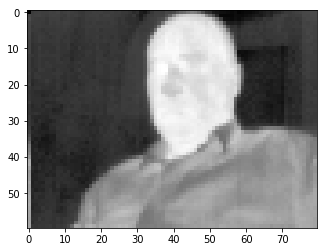

In [37]:
plt.imshow(pixels,cmap='gray')
plt.show()